In [1]:
import sys
sys.path.append('..')

In [88]:
from data_aquisition import twitter_data
from feature_engineering import features
import datetime as dt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import emojis
import pickle
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
pd.options.display.max_rows = 10000
pd.set_option('display.max_colwidth', 150)
pd.options.display.max_columns = 10000

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

In [5]:
labeled_data = features.import_labeled_data()

In [6]:
print(labeled_data.shape)
labeled_data.head()

(12044, 8)


,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point
0,2021-03-25 17:50:13+00:00,UCitnow,1375142994920271872,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,0.0,0,1.0,NaN
1,2021-03-25 17:50:48+00:00,UCitnow,1375143141058080768,RT @UCitnow: #RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,0.0,0,1.0,NaN
2,2021-03-25 18:47:48+00:00,Rad7RR,1375157484063584261,$AXTG Big OTC % Gainer!🚀🚀🚀,1.0,0,1.0,NaN
3,2021-03-25 20:02:03+00:00,GetScanz,1375176172099747845,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks… https://t.co/nBJ2yCqTZF,1.0,0,1.0,NaN
4,2021-03-25 20:02:48+00:00,christinebarnum,1375176361560604679,RT @GetScanz: Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks #hotstocks #otcbb #…,1.0,0,1.0,NaN


In [7]:
labeled_data.isna().any()

Datetime             True
user.screen_name     True
id_str               True
text                 True
Sentiment           False
Known_Pumper        False
Price_Region         True
Inflection_Point     True
dtype: bool

In [8]:
tweet_data = twitter_data.read_all_twitter_data(folder='../data_aquisition/twitter_raw_data/clean_data/')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pas

In [9]:
# Merging sentiment data to original dataset 
labeled_tweets = labeled_data[['id_str', 'Sentiment', 'Known_Pumper', 'Price_Region', 'Inflection_Point']].merge(tweet_data, on='id_str')

In [10]:
labeled_tweets.head()

,id_str,Sentiment,Known_Pumper,Price_Region,Inflection_Point,contributors,coordinates,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,favorite_count,favorited,geo,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,metadata.iso_language_code,metadata.result_type,place,place.bounding_box.coordinates,place.bounding_box.type,place.contained_within,place.country,place.country_code,place.full_name,place.id,place.name,place.place_type,place.url,possibly_sensitive,quoted_status.contributors,quoted_status.coordinates,quoted_status.created_at,quoted_status.entities.hashtags,quoted_status.entities.media,quoted_status.entities.symbols,quoted_status.entities.urls,quoted_status.entities.user_mentions,quoted_status.extended_entities.media,quoted_status.favorite_count,quoted_status.favorited,quoted_status.geo,quoted_status.id,quoted_status.id_str,quoted_status.in_reply_to_screen_name,quoted_status.in_reply_to_status_id,quoted_status.in_reply_to_status_id_str,quoted_status.in_reply_to_user_id,quoted_status.in_reply_to_user_id_str,quoted_status.is_quote_status,quoted_status.lang,quoted_status.metadata.iso_language_code,quoted_status.metadata.result_type,quoted_status.place,quoted_status.place.bounding_box.coordinates,quoted_status.place.bounding_box.type,quoted_status.place.contained_within,quoted_status.place.country,quoted_status.place.country_code,quoted_status.place.full_name,quoted_status.place.id,quoted_status.place.name,quoted_status.place.place_type,quoted_status.place.url,quoted_status.possibly_sensitive,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str,quoted_status.retweet_count,quoted_status.retweeted,quoted_status.source,quoted_status.text,quoted_status.truncated,quoted_status.user.contributors_enabled,quoted_status.user.created_at,quoted_status.user.default_profile,quoted_status.user.default_profile_image,quoted_status.user.description,quoted_status.user.entities.description.urls,quoted_status.user.entities.url.urls,quoted_status.user.favourites_count,quoted_status.user.follow_request_sent,quoted_status.user.followers_count,quoted_status.user.following,quoted_status.user.friends_count,quoted_status.user.geo_enabled,quoted_status.user.has_extended_profile,quoted_status.user.id,quoted_status.user.id_str,quoted_status.user.is_translation_enabled,quoted_status.user.is_translator,quoted_status.user.lang,quoted_status.user.listed_count,quoted_status.user.location,quoted_status.user.name,quoted_status.user.notifications,quoted_status.user.profile_background_color,quoted_status.user.profile_background_image_url,quoted_status.user.profile_background_image_url_https,quoted_status.user.profile_background_tile,quoted_status.user.profile_banner_url,quoted_status.user.profile_image_url,quoted_status.user.profile_image_url_https,quoted_status.user.profile_link_color,quoted_status.user.profile_sidebar_border_color,quoted_status.user.profile_sidebar_fill_color,quoted_status.user.profile_text_color,quoted_status.user.profile_use_background_image,quoted_status.user.protected,quoted_status.user.screen_name,quoted_status.user.statuses_count,quoted_status.user.time_zone,quoted_status.user.translator_type,quoted_status.user.url,quoted_status.user.utc_offset,quoted_status.user.verified,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status.contributors,retweeted_status.coordinates,retweeted_status.created_at,retweeted_status.entities.hashtags,retweeted_status.entities.media,retweeted_status.entities.symbols,retweeted_status.entities.urls,retweeted_status.entities.user_mentions,retweeted_status.extended_entities.media,retweeted_status.favorite_count,retweeted_status.favorited,retweeted_status.geo,retweeted_status.id,retweeted_status.id_str,retweeted_status.in_reply_to_screen_name,retweeted_status.in_reply_to_status_id,retweeted_status.in_reply_to_status_id

In [11]:
# Filter down to columns we want to focus on for sentiment model 
labeled_tweets[['id_str','text', 'entities.hashtags', 'Sentiment']].head(50)

,id_str,text,entities.hashtags,Sentiment
0,1375142994920271872,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,"[{'text': 'RT', 'indices': [0, 3]}]",0.0
1,1375143141058080768,RT @UCitnow: #RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EVO9MRPLEASE $AXTG New intern CEO https://t.co/oCOI6nRC6G,"[{'text': 'RT', 'indices': [13, 16]}]",0.0
2,1375157484063584261,$AXTG Big OTC % Gainer!🚀🚀🚀,[],1.0
3,1375176172099747845,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks… https://t.co/nBJ2yCqTZF,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0
4,1375176361560604679,RT @GetScanz: Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks #hotstocks #otcbb #…,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0
5,1375182761229684742,RT @GetScanz: Today’s Top Penny Stock Gainers\n\n$LTTGF $AXTG $SEVA $AFOM $DVLP $RGBPP $GNPK-WS $IMMP $ETFM\n\n#pennystocks #hotstocks #otcbb #…,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0
6,1375455671689170953,That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so ma… https://t.co/tIDWrRkVNa,[],1.0
7,1375455908470386697,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0
8,1375456626392596484,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0
9,1375456640745369601,RT @jehause: That is a great point! NFT is huge and $HMBL has all the tools in place to become a player. Shareholders have so many catalyst…,[],1.0


In [12]:
train_data = labeled_tweets[['text', 'entities.hashtags', 'Sentiment', 'Price_Region', 'Inflection_Point', 'Known_Pumper']]

In [13]:
# Removing -2 values on sentiment
train_data = train_data[train_data['Sentiment'] > -2.0]
train_data = train_data.dropna(subset=['Sentiment', 'text'])
train_data.shape

(12043, 6)

In [14]:
# Change all text to lowercase
train_data['text'] = train_data['text'].str.lower()

In [15]:
# Remove all periods and commas, delete preceding spaces
train_data['text'] = train_data['text'].str.replace(',', '')
train_data['text'] = train_data['text'].str.replace('.', '')
train_data['text'] = train_data['text'].str.strip()
# Remove the '...'
train_data['text'] = train_data['text'].str.replace(r'…', '', regex=True)

In [16]:
# Remove hyperlinks
train_data['text'] = train_data['text'].replace(r'http\S+', '', regex=True)

In [17]:
# Remove chinese characters
# train_data['text'] = train_data['text'].replace(r'[\p{script=Han}]', '', regex=True)

In [18]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0
2,$axtg big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0
3,today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0
4,rt @getscanz: today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0


In [19]:
train_data.iloc[3]['text']

'today’s top penny stock gainers\n\n$lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm\n\n#pennystocks '

In [20]:
# Replace \n with a space 
train_data['text'] = train_data['text'].replace(r'\n', ' ', regex=True)

In [21]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease $axtg new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0
2,$axtg big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0
3,today’s top penny stock gainers $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0
4,rt @getscanz: today’s top penny stock gainers $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0


In [22]:
train_data.iloc[3]['text']

'today’s top penny stock gainers  $lttgf $axtg $seva $afom $dvlp $rgbpp $gnpk-ws $immp $etfm  #pennystocks '

In [23]:
# Remove stock tags
train_data['text'] = train_data['text'].replace(r'\$\S+', '', regex=True)

In [24]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper
0,#rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0
1,rt @ucitnow: #rt @ldev117: rt @ucitnow: @shortsqueezed1 @evo9mrplease new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0
4,rt @getscanz: today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0


In [25]:
train_data.iloc[3]['text']

'today’s top penny stock gainers            #pennystocks '

In [26]:
train_data.iloc[4]['text']

'rt @getscanz: today’s top penny stock gainers            #pennystocks #hotstocks #otcbb #'

In [27]:
# Create feature for number of exclamation marks
train_data['exc_count'] = train_data['text'].map(lambda x: x.count("!"))

In [28]:
# Create a column for number of characters 
train_data['characters_nb'] = train_data.text.apply(len)

In [29]:
# Remove tags
train_data['text'] = train_data['text'].replace(r'\@\S+', '', regex=True)

In [30]:
# Add count for emojis
train_data['emoji_count'] = train_data['text'].map(lambda x: emojis.count(x))

In [31]:
# Create decoded version of text field
train_data['text_dec'] = train_data['text'].map(lambda x: emojis.decode(x))

In [32]:
# Add spaces around emojis so they can be separated as words 
train_data['text_dec'] = train_data['text_dec'].replace(r'(:[a-z]+:)', ' \\1 ', regex=True)

In [33]:
train_data.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0,0,73,0,#rt rt new intern ceo
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0,0,86,0,rt #rt rt new intern ceo
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0,0,56,0,today’s top penny stock gainers #pennystocks
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #


In [34]:
train_data.iloc[3]['text_dec']

'today’s top penny stock gainers            #pennystocks '

In [35]:
train_data.isna().any()

text                 False
entities.hashtags    False
Sentiment            False
Price_Region          True
Inflection_Point      True
Known_Pumper         False
exc_count            False
characters_nb        False
emoji_count          False
text_dec             False
dtype: bool

In [104]:
train_data.shape

(12043, 10)

# Text mining

In [36]:
# Adding plots from midterm
def top_words(df, field, label_col, top_words_num):
    topWords = []
    df = df[df[label_col].notna()]
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+|:[a-z]+:')
    labels = df[label_col].unique()
    print("Labels for {}:".format(label_col))
    print(labels)
    for label in labels:
        # print("Top {} words for Score = {}".format(top_words_num, i))
        # print(df[df['Score'] == float(i)][field].head())
        # print(df[df['Score'] == float(i)][field].tolist()[878:880])
        words = pd.Series(tokenizer.tokenize(' '.join(df[df['Sentiment'] == float(label)][field].dropna().tolist())))
        topWordsForScore = words.where(~words.index.isin(stopwords.words()))
        # print(topWordsForScore.head())
        # print(topWordsForScore.shape)
        
#         print(topWordsForScore.value_counts()[:top_words_num].index.tolist())
#         print()
        topWords.append(topWordsForScore)
    
    for i, label in zip(range(len(topWords)), labels):
    
        fig, ax = plt.subplots(figsize=(30,15))
        allExcepti = topWords[:i] + topWords[i+1:]
        flattened = pd.concat(allExcepti)
        topWords[i] = topWords[i].where(~topWords[i].index.isin(flattened.value_counts()[:top_words_num].index.tolist()))
        print("Top {} words sort of unique to {} = {}".format(top_words_num, label_col, label))
        print(topWords[i].value_counts()[:top_words_num].index.tolist())
        print()
        topWords[i].value_counts()[:top_words_num].plot(kind='bar', ax=ax)
        plt.title("Top {} word counts unique to {} = {}".format(top_words_num, label_col, label))
        plt.savefig('{}_{}.png'.format(label_col, label))
        plt.show()
        

In [102]:
'for' in stopwords.words()

True

Labels for Sentiment:
[ 0.  1. -1.]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Top 50 words sort of unique to Sentiment = 0.0
['rt', 'to', 'the', 'and', ':', 'for', 'of', 'on', 'in', '%', 'i', 'at', 'a', '-', 'news', ':star:', 'will', 'be', '&amp;', 'is', '2021', 'day', ':fire:', 'from', 'today', '️', 'march', 'you', 'this', 'any', 'it', 'acquisition', 'with', 'new', 'once', 'company', 'pps', 'inc', 'listed', 'million', 'up', 'order', 'highest', 'lowest', '!', '?', 'we', 'my', '20', 'if']



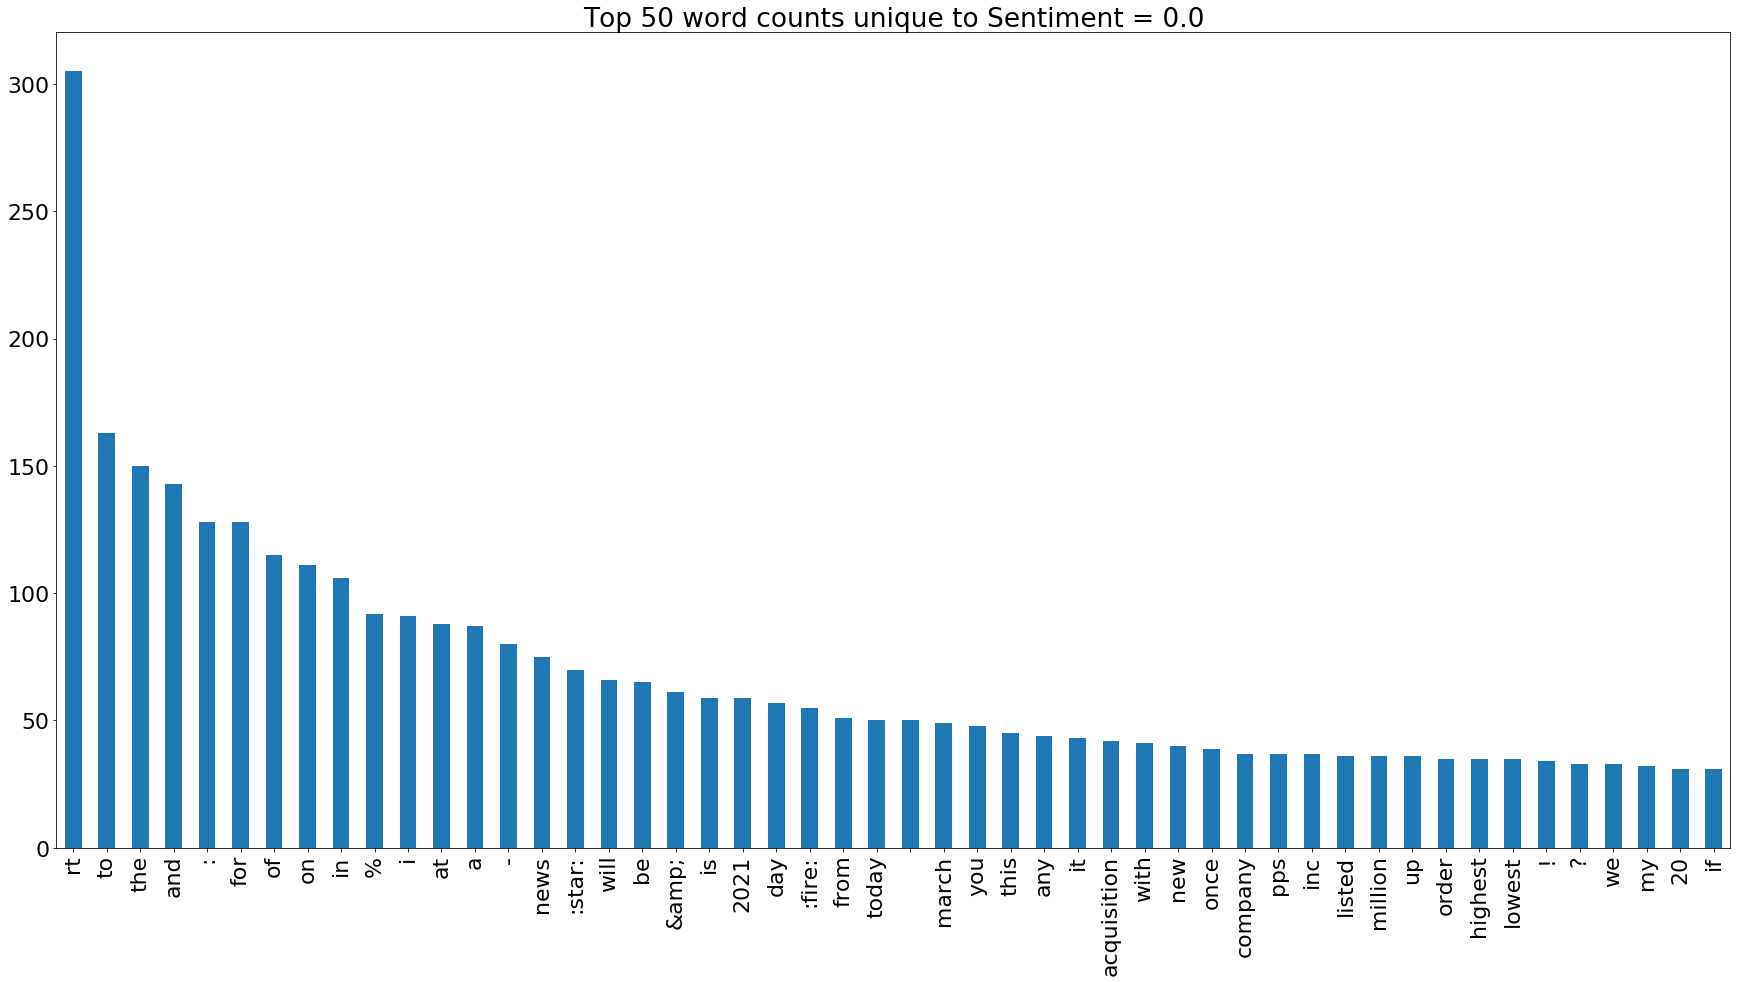

Top 50 words sort of unique to Sentiment = 1.0
[':rocket:', ':fire:', 'rt', 'the', 'to', '!', 'this', 'is', ':moneybag:', ':gem:', 'in', 'i', 'on', 'and', '🛢', 'a', 'of', 'for', ':collision:', 'it', 'you', '’s', ':thinking:', 'up', 'be', 'my', 'we', '3', ':dollar:', 'oil', ':eyes:', 'will', 'going', 'today', ':dash:', 'news', '-', 'out', 'get', 'like', 'week', 'at', 'if', 'have', '%', '?', 'are', 'now', 'go', 'that']



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 57058 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 128738 missing from current font.
  font.load_char(ord(s), flags=flags)


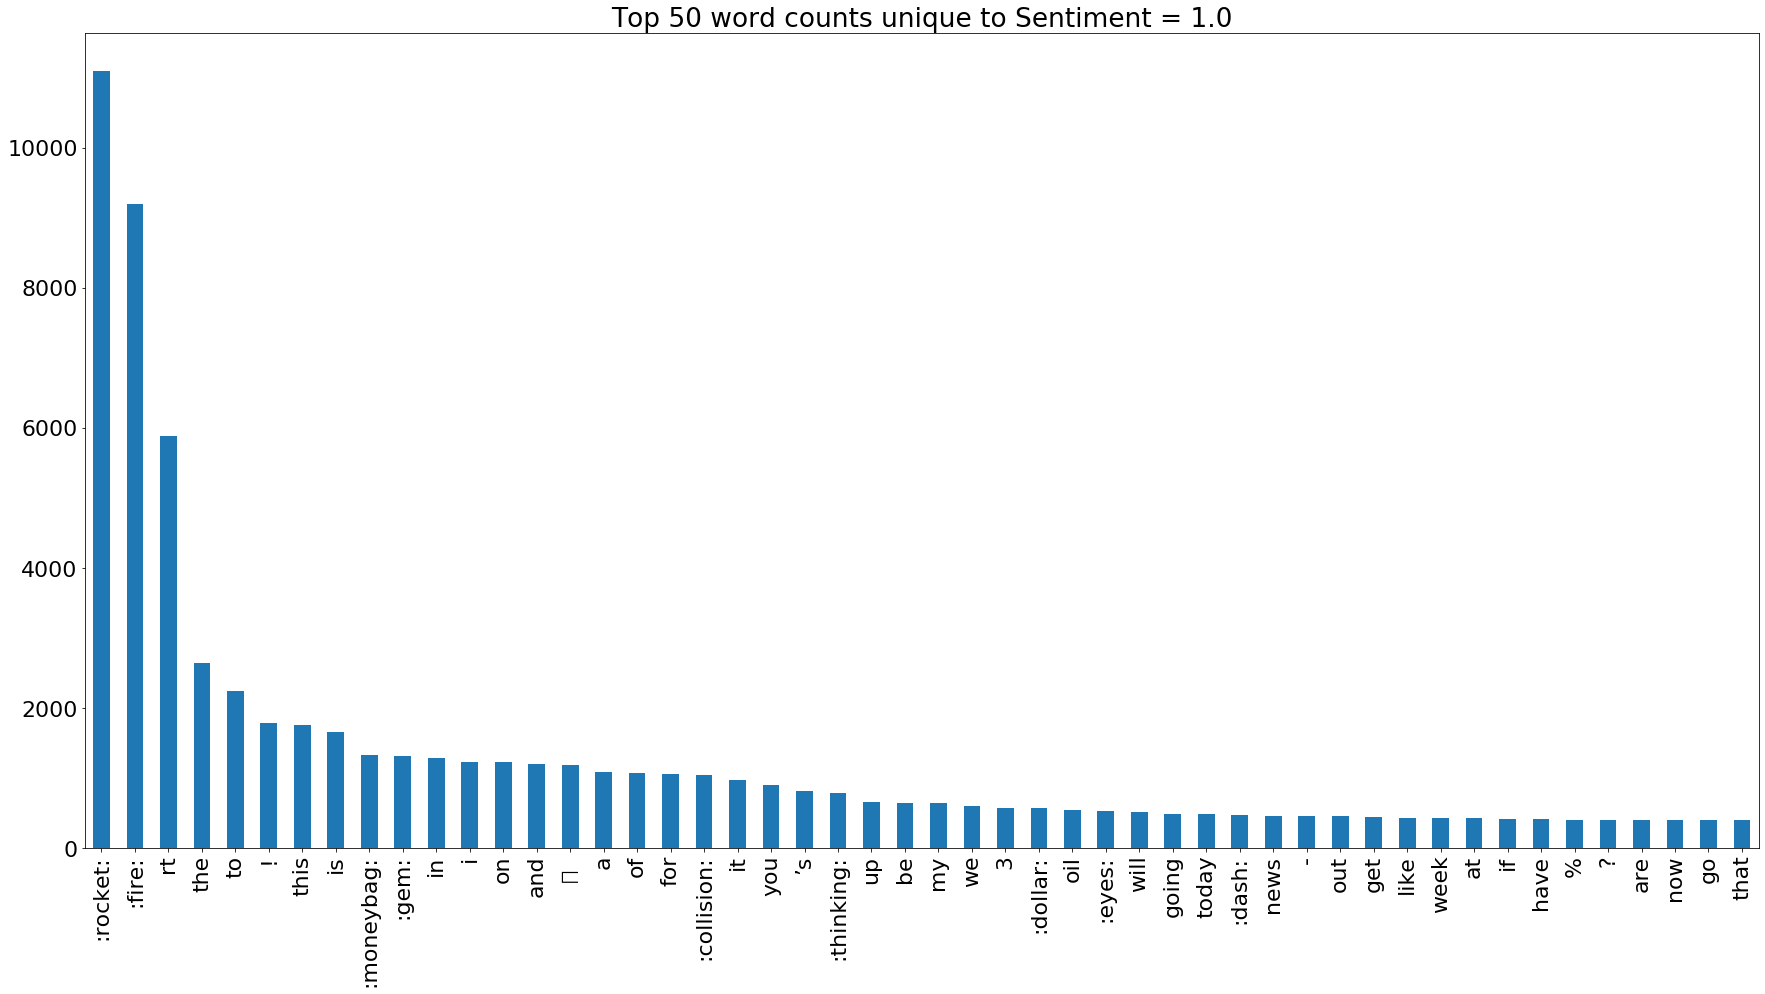

Top 50 words sort of unique to Sentiment = -1.0
['the', 'a', 'i', 'to', 'and', 'rt', 'is', 'it', 'this', 'dump', 'you', 'on', 'for', 'of', 'that', 'pump', 'in', 'up', 'offering', 'they', '!', 'from', 'at', '&amp;', 'now', 'into', 'be', 'but', '-', 'my', 'all', '?', 'sorry', 'have', 'news', 'sell', 'out', 'oil', 'like', 'if', 'today', 'not', '%', 'us', 'as', 'off', 'are', 'your', 'so', 'with']



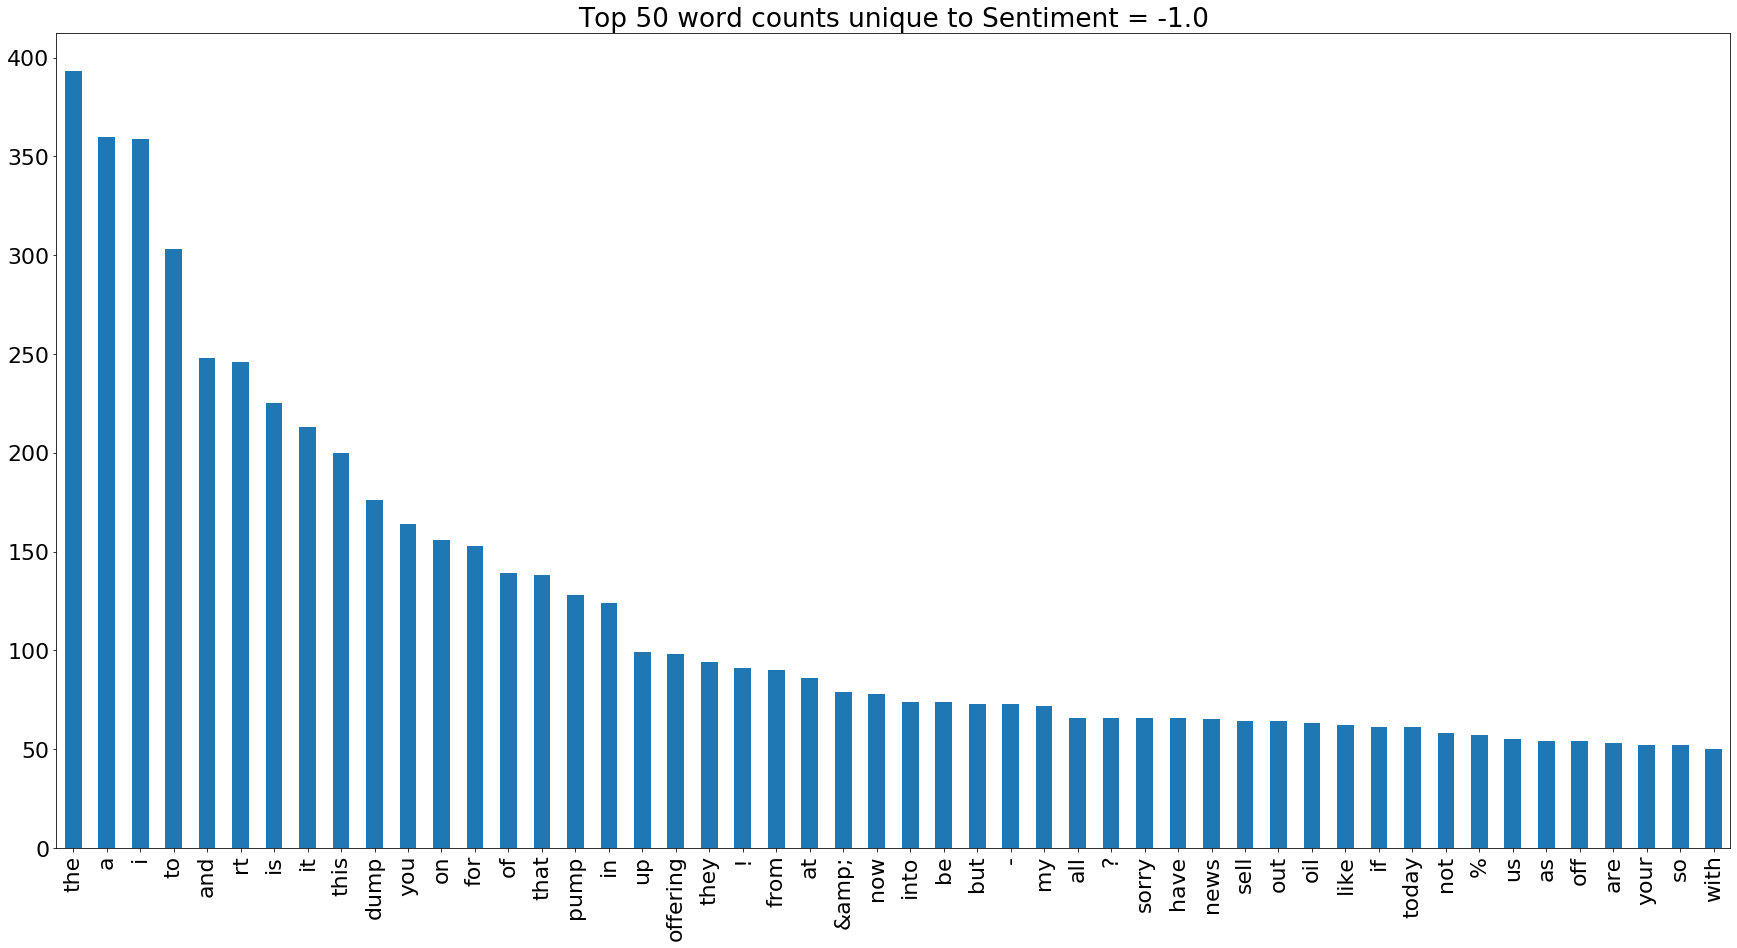

In [37]:
top_words(train_data, 'text_dec', 'Sentiment', 50)

Labels for Inflection_Point:
[ 1. -1.]
Top 50 words sort of unique to Inflection_Point = 1.0
[':rocket:', ':fire:', 'rt', '!', 'to', 'the', ':moneybag:', 'is', '1', 'current', 'this', 'on', '2', 'you', 'oil', '4', '-', 'of', '3', 'list', 'and', 'my', 'for', 'i', ':gem:', 'monday', ':dollar:', 'in', 'gold', '’s', 'excited', '&amp;', 'merger', 'fuck', 'cheap', 'top', ':eyes:', 'jane', 'week', '🛢', 'quie', '?', 'a', 'up', 'what', 'be', 'like', 'out', 'will', 'it']



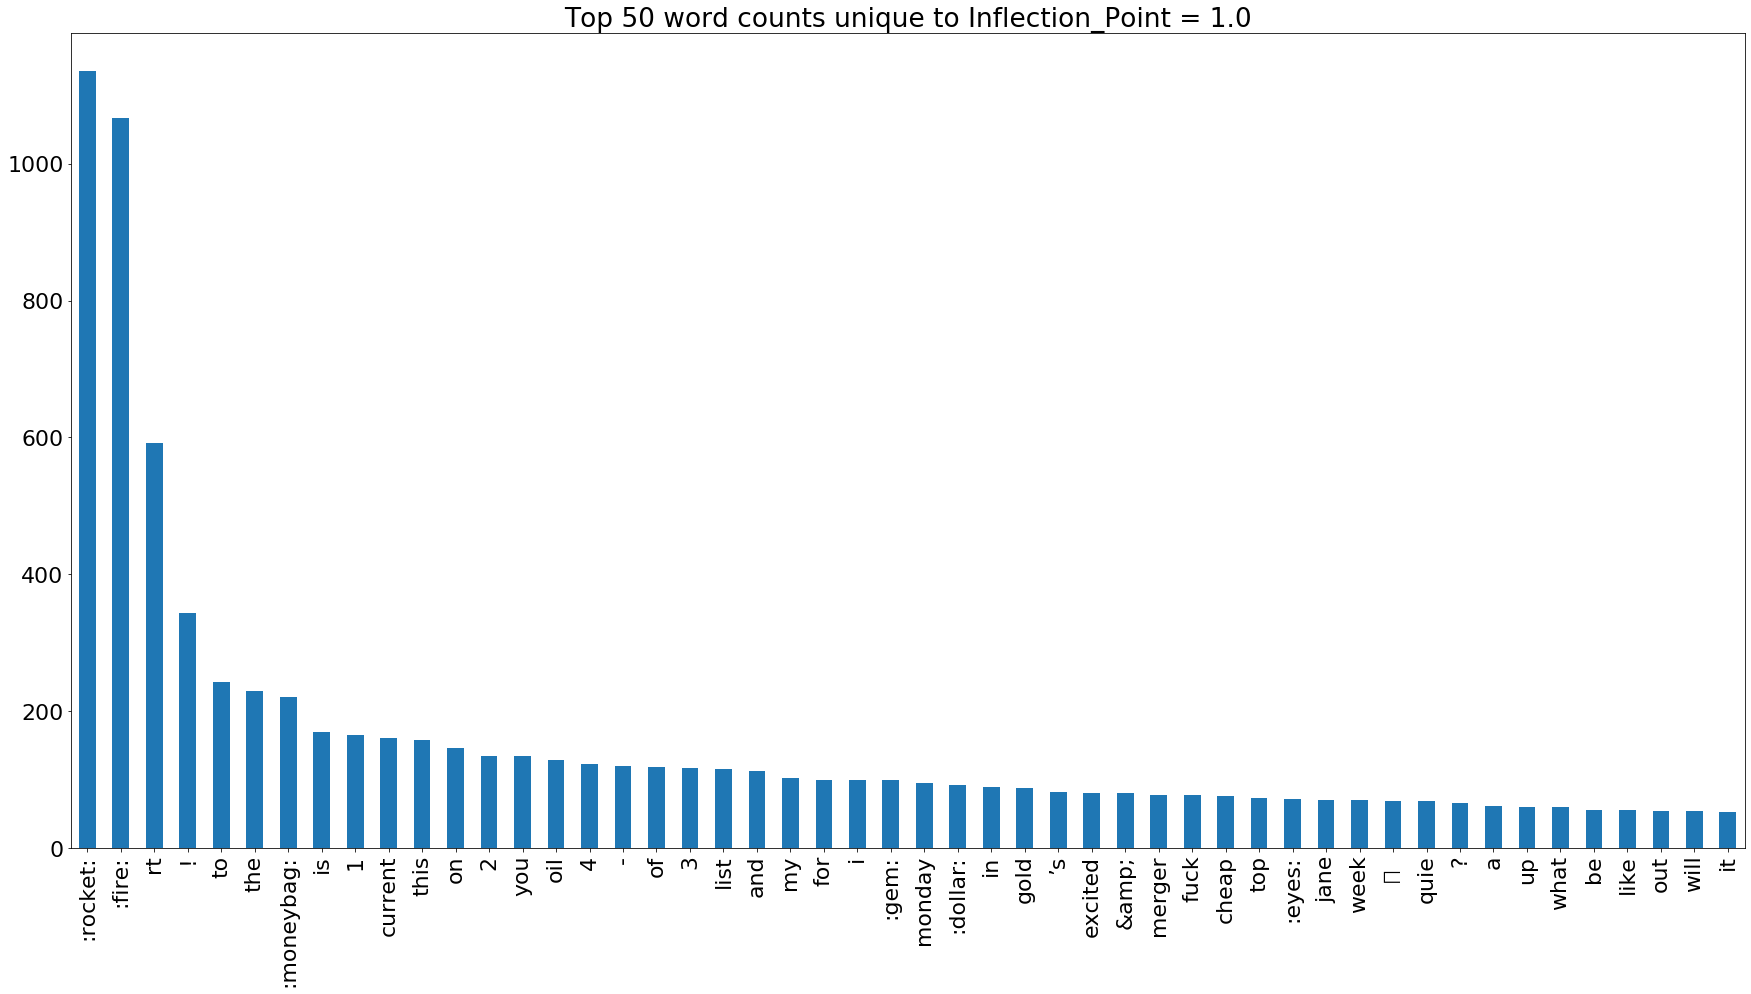

Top 50 words sort of unique to Inflection_Point = -1.0
['the', 'to', 'offering', 'a', 'i', 'of', 'it', 'rt', 'and', 'is', 'you', 'this', 'have', 'public', 'into', 'proposed', 'at', 'be', 'in', 'for', 'just', 'on', 'they', 'that', 'what', 'announces', 'stock', 'no', 'common', 'fuck', 'news', 'underwritten', 'so', 'seachange', 'all', 'too', 'us', 'these', 'international', '8', 'equipment', 'can', 'hope', 'up', '!', 'our', '#jane', 'come', 'mms', 'as']



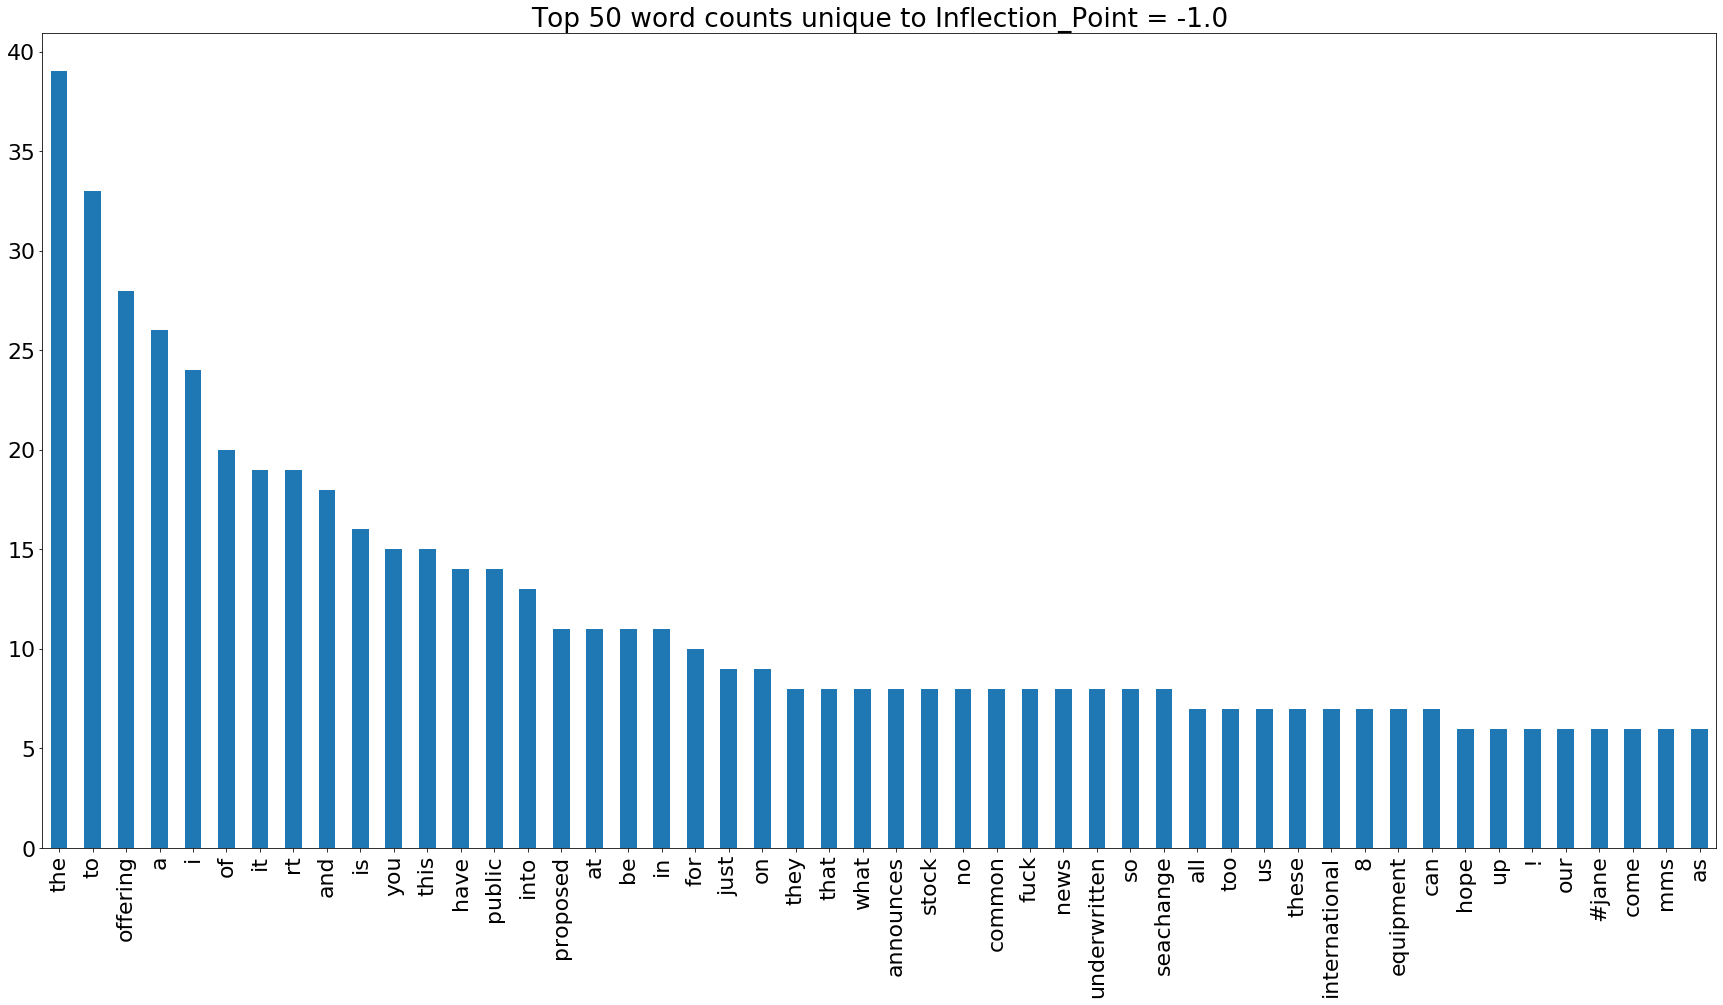

In [38]:
top_words(train_data, 'text_dec', 'Inflection_Point', 50)

In [38]:
reg_ex_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+|:[a-z]+:')
vectorizer = CountVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=100, strip_accents='ascii')
train_data_vec = vectorizer.fit_transform(train_data['text_dec'])
print("Count vector shape of X_train: {}".format(train_data.shape))

# Code for adding feature back on df 
count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
train_data_cv = pd.concat([train_data, count_vect_df], axis=1)
# train_data_cv = train_data_cv.dropna(subset=['Sentiment'])
train_data_cv.head()

Count vector shape of X_train: (12043, 10)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#otc,#solana,$,%,&amp;,'m,'s,'t,),+,-,/30()19,1,10,1010,2,20,2021,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,acquisition,ath,baby,big,bought,buy,cheap,check,come,coming,company,current,day,days,dd,dip,dont,dump,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,love,low,make,making,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,pump,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,strong,support,think,time,today,tomorrow,trading,tweet,update,volume,watchlist,week,weekend,world,year,youre
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0,0,73,0,#rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0,0,86,0,rt #rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0,0,56,0,today’s top penny stock gainers #pennystocks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
print(train_data_cv['Sentiment'].unique())
train_data_cv[train_data_cv.isna()].head()

[ 0.  1. -1.]


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#otc,#solana,$,%,&amp;,'m,'s,'t,),+,-,/30()19,1,10,1010,2,20,2021,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,acquisition,ath,baby,big,bought,buy,cheap,check,come,coming,company,current,day,days,dd,dip,dont,dump,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,love,low,make,making,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,pump,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,strong,support,think,time,today,tomorrow,trading,tweet,update,volume,watchlist,week,weekend,world,year,youre
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data.drop(['Sentiment'], axis=1), train_data['Sentiment'], test_size=1/4.0, random_state=0)

In [41]:
X_train = X_train[['exc_count', 'characters_nb', 'emoji_count']]
X_test = X_test[['exc_count', 'characters_nb', 'emoji_count']]
X_train.head()

,exc_count,characters_nb,emoji_count
7482,0,130,5
3083,3,62,5
791,0,23,0
8640,1,78,0
7475,0,130,5


In [42]:
Y_train.head()

7482    1.0
3083    1.0
791     1.0
8640    1.0
7475    1.0
Name: Sentiment, dtype: float64

In [43]:
# Define models to test
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB())
        ]

In [44]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8425772168714712
RF
0.8571903022251743
KNN
0.8482231816672202
SVM
0.8425772168714712
GNB
0.8346064430421787


In [45]:
# Now trying with countvectorizer
X_train, X_test, Y_train, Y_test = train_test_split(train_data_cv.loc[:, '!':], train_data_cv['Sentiment'], test_size=1/4.0, random_state=0)

In [46]:
X_train.head()

,!,!!,!!!,!!!!,#,#88e,#nft,#otc,#solana,$,%,&amp;,'m,'s,'t,),+,-,/30()19,1,10,1010,2,20,2021,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,acquisition,ath,baby,big,bought,buy,cheap,check,come,coming,company,current,day,days,dd,dip,dont,dump,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,love,low,make,making,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,pump,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,strong,support,think,time,today,tomorrow,trading,tweet,update,volume,watchlist,week,weekend,world,year,youre
7482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8640,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [47]:
# Adding scaling - not added yet but leaving here for now
from sklearn.preprocessing import MinMaxScaler

In [48]:
# x_scaled = MinMaxScaler().fit_transform(X_train)
# df = pd.DataFrame(x_scaled)
# df.head()

In [49]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg
0.8747924277648622
RF
0.878445699103288
KNN
0.8688143473928928
SVM
0.8688143473928928
GNB
0.4775821986051146


In [50]:
# Trying TfiDf
vectorizer = TfidfVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=100, strip_accents='ascii')
train_data_vec = vectorizer.fit_transform(train_data['text_dec'])
print("Count vector shape of X_train: {}".format(train_data.shape))

# Code for adding feature back on df 
count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
train_data_tf = pd.concat([train_data, count_vect_df], axis=1)
train_data_tf = train_data_tf.dropna(subset=['Sentiment'])
train_data_tf.head()

Count vector shape of X_train: (12043, 10)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,!,!!,!!!,!!!!,#,#88e,#nft,#otc,#solana,$,%,&amp;,'m,'s,'t,),+,-,/30()19,1,10,1010,2,20,2021,250,3,4,5,7000,:,:bangbang:,:chart_with_upwards_trend:,:collision:,:dollar:,:eyes:,:fire:,:gem:,:joy:,:money_mouth_face:,:moneybag:,:muscle:,:pray:,:rocket:,:rotating_light:,:slot_machine:,:smirk:,:sunglasses:,:white_check_mark:,?,acquisition,ath,baby,big,bought,buy,cheap,check,come,coming,company,current,day,days,dd,dip,dont,dump,early,energy,excited,float,ftx,fuck,going,gold,gonna,good,got,great,green,high,hit,hold,holding,hope,huge,im,just,know,let,lets,like,list,long,looking,love,low,make,making,market,mil,million,monday,money,moon,morning,need,new,news,nice,oil,otc,penny,people,pink,play,post,price,pump,read,ready,right,rt,run,shares,short,soon,squeeze,stock,stocks,strong,support,think,time,today,tomorrow,trading,tweet,update,volume,watchlist,week,weekend,world,year,youre
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0,0,73,0,#rt rt new intern ceo,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.941231,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337764,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0,0,86,0,rt #rt rt new intern ceo,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812417,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583077,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0.283389,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.386645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.567667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.465047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.481334,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0,0,56,0,today’s top penny stock gainers #pennystocks,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.761238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.648472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [51]:
# Now trying with countvectorizer
X_train, X_test, Y_train, Y_test = train_test_split(train_data_tf.loc[:, '!':], train_data_tf['Sentiment'], test_size=1/4.0, random_state=0)

In [52]:
for name, model in models:
    print(name)
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(accuracy_score(Y_test, y_pred))

LogReg
0.8741281966124211
RF
0.8801062769843906
KNN
0.8571903022251743
SVM
0.8787778146795084
GNB
0.35469943540352045


## Matt's code for determining word frequency

In [53]:
import nltk
from collections import Counter

In [54]:
# Matt's code
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
textWords = (train_data.text.str.lower().replace([r'\|', RE_stopwords], [' ', ''], regex=True).str.cat(sep=' ').split())
textRslt = pd.DataFrame(Counter(textWords).most_common(100), columns=['Word', 'Frequency']).set_index('Word')

In [55]:
textRslt.head(50)

,Frequency
Word,
rt,6439
’,1405
🚀,1289
🔥,1041
-,565
news,556
',543
going,521
&amp;,518


# Creating pipeline 

In [56]:
import vocab

In [57]:
vocab_list = vocab.get_all_vocab()
print(vocab_list)

['news', 'update', 'alert', 'company', '2021', 'available', '#stocks', 'free', ':brain:', 'hold', ':rocket:', ':fire:', 'rocket', ':moneybag:', 'buy', ':pray:', ':dollar:', 'moon', ':bangbang:', ':gem:', ':slot_machine:house', 'rich', ':eyes:', ':collision:', 'ath', 'offering', 'dump', 'short', 'public', 'proposed', 'down', 'red', 'dip', 'diamond', 'pump and dump', 'out', 'sell', 'sold', 'current', 'list', 'gold', 'excited', 'cheap', 'merger', 'bad', 'underwritten', 'wait', 'see', 'annouces', 'profit']


In [58]:
def add_features():
    return None

In [59]:
def apply_countvectorizer(df, text_col, min_df=1, vocab_def=None):
    vectorizer = CountVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=min_df, strip_accents='ascii', vocabulary=vocab_def)
    train_data_vec = vectorizer.fit_transform(df[text_col])
    print("Count vector shape of vectorized data: {}".format(train_data_vec.shape))
    # Code for adding feature back on df 
    count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
    train_data_cv = pd.concat([df, count_vect_df], axis=1)
    return train_data_cv

In [60]:
def apply_tfidf(df, text_col, min_df=1, vocab_def=None):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern='\w+|\$[\d\.]+|\S+|:[a-z]+:', min_df=min_df, strip_accents='ascii', vocabulary=vocab_def)
    train_data_vec = vectorizer.fit_transform(df[text_col])
    print("Count vector shape of vectorized data: {}".format(train_data_vec.shape))
    # Code for adding feature back on df 
    count_vect_df = pd.DataFrame(train_data_vec.todense(), columns=vectorizer.get_feature_names())
    train_data_tf = pd.concat([df, count_vect_df], axis=1)
    return train_data_tf

In [61]:
def run_models(model_list, X_train, X_test, Y_train, Y_test, labels=None):
    for name, model in model_list:
        print(name)
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold)
        clf = model.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print(accuracy_score(Y_test, y_pred))
        plot_confusion_matrix(clf, X_test, Y_test)
        plt.show()
        print(classification_report(Y_test, y_pred, labels=labels))
        print("Average test score cross validation results: {}".format(cv_results['test_score'].mean()))
           

In [108]:
train_cv_vocab = apply_countvectorizer(train_data, 'text_dec', vocab_def=vocab_list)
train_cv_vocab.head()

Count vector shape of vectorized data: (12043, 50)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0,0,73,0,#rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0,0,86,0,rt #rt rt new intern ceo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0,0,56,0,today’s top penny stock gainers #pennystocks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
train_cv_vocab.isna().sum()

text                       0
entities.hashtags          0
Sentiment                  0
Price_Region              61
Inflection_Point       10758
Known_Pumper               0
exc_count                  0
characters_nb              0
emoji_count                0
text_dec                   0
news                       0
update                     0
alert                      0
company                    0
2021                       0
available                  0
#stocks                    0
free                       0
:brain:                    0
hold                       0
:rocket:                   0
:fire:                     0
rocket                     0
:moneybag:                 0
buy                        0
:pray:                     0
:dollar:                   0
moon                       0
:bangbang:                 0
:gem:                      0
:slot_machine:house        0
rich                       0
:eyes:                     0
:collision:                0
ath           

In [110]:
train_cv_vocab.dropna(subset=['Sentiment'], inplace=True)
train_cv_vocab['Sentiment'].unique()

array([ 0.,  1., -1.])

In [111]:
train_cv_vocab.shape

(12043, 60)

In [64]:
train_tf_vocab = apply_tfidf(train_data, 'text_dec', vocab_def=vocab_list)
train_tf_vocab.head()

Count vector shape of vectorized data: (12043, 50)


,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,#rt rt new intern ceo,"[{'text': 'RT', 'indices': [0, 3]}]",0.0,1.0,NaN,0,0,73,0,#rt rt new intern ceo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt #rt rt new intern ceo,"[{'text': 'RT', 'indices': [13, 16]}]",0.0,1.0,NaN,0,0,86,0,rt #rt rt new intern ceo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,big otc % gainer!🚀🚀🚀,[],1.0,1.0,NaN,0,1,21,3,big otc % gainer! :rocket: :rocket: :rocket:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,today’s top penny stock gainers #pennystocks,"[{'text': 'pennystocks', 'indices': [93, 105]}]",1.0,1.0,NaN,0,0,56,0,today’s top penny stock gainers #pennystocks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,"[{'text': 'pennystocks', 'indices': [107, 119]}, {'text': 'hotstocks', 'indices': [120, 130]}, {'text': 'otcbb', 'indices': [131, 137]}]",1.0,1.0,NaN,0,0,89,0,rt today’s top penny stock gainers #pennystocks #hotstocks #otcbb #,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
train_tf_vocab.dropna(subset=['Sentiment'], inplace=True)
train_tf_vocab['Sentiment'].unique()
train_tf_vocab.isna().sum()

text                       0
entities.hashtags          0
Sentiment                  0
Price_Region              61
Inflection_Point       10758
Known_Pumper               0
exc_count                  0
characters_nb              0
emoji_count                0
text_dec                   0
news                       0
update                     0
alert                      0
company                    0
2021                       0
available                  0
#stocks                    0
free                       0
:brain:                    0
hold                       0
:rocket:                   0
:fire:                     0
rocket                     0
:moneybag:                 0
buy                        0
:pray:                     0
:dollar:                   0
moon                       0
:bangbang:                 0
:gem:                      0
:slot_machine:house        0
rich                       0
:eyes:                     0
:collision:                0
ath           

In [113]:
X_train_cv, X_test_cv, Y_train_cv, Y_test_cv = train_test_split(train_cv_vocab.loc[:, 'news':], train_cv_vocab['Sentiment'], test_size=1/4.0, random_state=0)

In [115]:
X_train_cv.shape

(9032, 50)

LogReg
0.8761208900697443


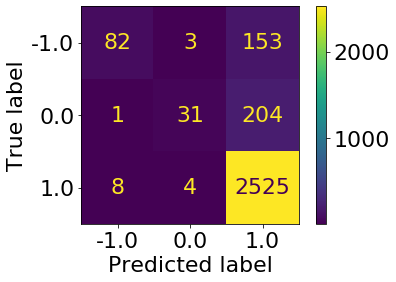

              precision    recall  f1-score   support

        -1.0       0.90      0.34      0.50       238
         0.0       0.82      0.13      0.23       236
         1.0       0.88      1.00      0.93      2537

    accuracy                           0.88      3011
   macro avg       0.86      0.49      0.55      3011
weighted avg       0.87      0.88      0.84      3011

Average test score cross validation results: 0.8800934718619177
RF
0.8751245433410827


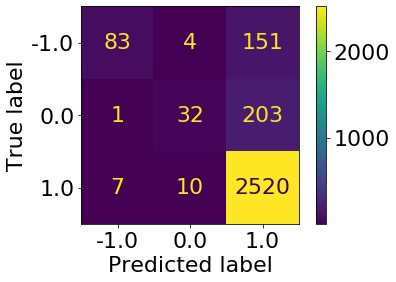

              precision    recall  f1-score   support

        -1.0       0.91      0.35      0.50       238
         0.0       0.70      0.14      0.23       236
         1.0       0.88      0.99      0.93      2537

    accuracy                           0.88      3011
   macro avg       0.83      0.49      0.55      3011
weighted avg       0.87      0.88      0.84      3011

Average test score cross validation results: 0.880867991525512
KNN
0.751909664563268


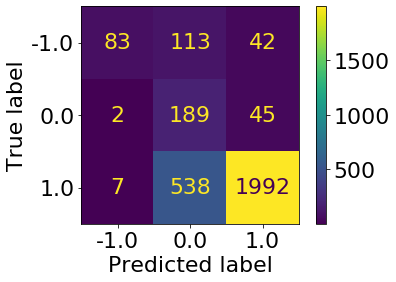

              precision    recall  f1-score   support

        -1.0       0.90      0.35      0.50       238
         0.0       0.23      0.80      0.35       236
         1.0       0.96      0.79      0.86      2537

    accuracy                           0.75      3011
   macro avg       0.70      0.64      0.57      3011
weighted avg       0.90      0.75      0.79      3011

Average test score cross validation results: 0.875664222008542
SVM
0.8737960810362005


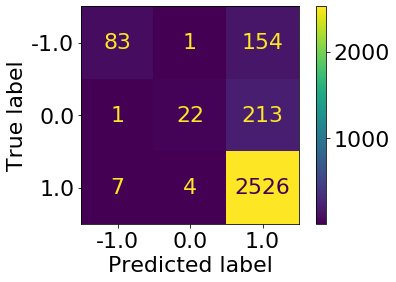

              precision    recall  f1-score   support

        -1.0       0.91      0.35      0.50       238
         0.0       0.81      0.09      0.17       236
         1.0       0.87      1.00      0.93      2537

    accuracy                           0.87      3011
   macro avg       0.87      0.48      0.53      3011
weighted avg       0.87      0.87      0.84      3011

Average test score cross validation results: 0.8796505039770892
GNB
0.42909332447691795


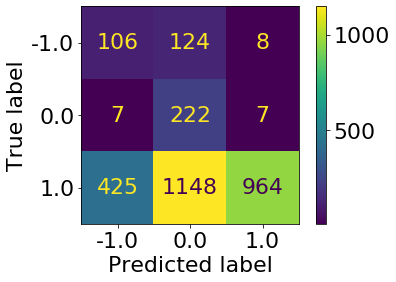

              precision    recall  f1-score   support

        -1.0       0.20      0.45      0.27       238
         0.0       0.15      0.94      0.26       236
         1.0       0.98      0.38      0.55      2537

    accuracy                           0.43      3011
   macro avg       0.44      0.59      0.36      3011
weighted avg       0.86      0.43      0.50      3011

Average test score cross validation results: 0.42437818720234644


In [114]:
# Testing countvectorizer with specified words
run_models(models, X_train_cv, X_test_cv, Y_train_cv, Y_test_cv)

In [116]:
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(train_tf_vocab.loc[:, 'news':], train_tf_vocab['Sentiment'], test_size=1/4.0, random_state=0)

In [119]:
X_test_tf.shape

(3011, 50)

LogReg
0.8737960810362005


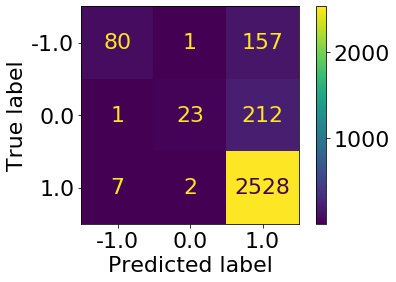

              precision    recall  f1-score   support

        -1.0       0.91      0.34      0.49       238
         0.0       0.88      0.10      0.18       236
         1.0       0.87      1.00      0.93      2537

    accuracy                           0.87      3011
   macro avg       0.89      0.48      0.53      3011
weighted avg       0.88      0.87      0.84      3011

Average test score cross validation results: 0.8790972231159616
RF
0.8781135835270674


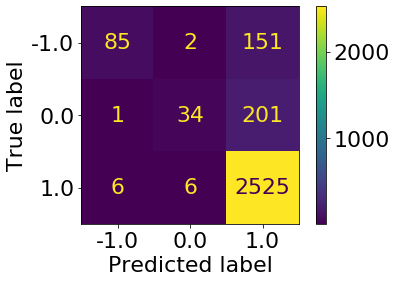

              precision    recall  f1-score   support

        -1.0       0.92      0.36      0.52       238
         0.0       0.81      0.14      0.24       236
         1.0       0.88      1.00      0.93      2537

    accuracy                           0.88      3011
   macro avg       0.87      0.50      0.56      3011
weighted avg       0.88      0.88      0.85      3011

Average test score cross validation results: 0.881864607981389
KNN
0.8688143473928928


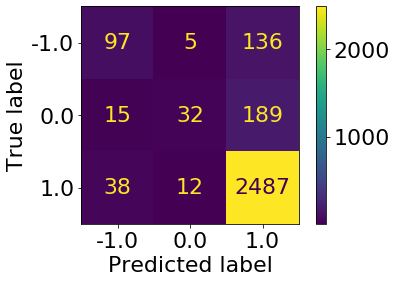

              precision    recall  f1-score   support

        -1.0       0.65      0.41      0.50       238
         0.0       0.65      0.14      0.22       236
         1.0       0.88      0.98      0.93      2537

    accuracy                           0.87      3011
   macro avg       0.73      0.51      0.55      3011
weighted avg       0.85      0.87      0.84      3011

Average test score cross validation results: 0.8225235809308085
SVM
0.8764530056459648


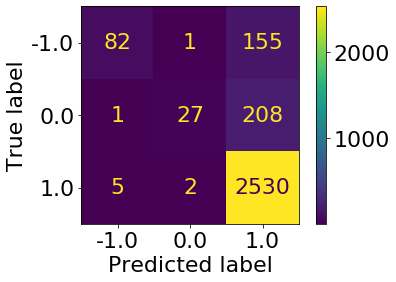

              precision    recall  f1-score   support

        -1.0       0.93      0.34      0.50       238
         0.0       0.90      0.11      0.20       236
         1.0       0.87      1.00      0.93      2537

    accuracy                           0.88      3011
   macro avg       0.90      0.49      0.55      3011
weighted avg       0.88      0.88      0.84      3011

Average test score cross validation results: 0.8817541724351159
GNB
0.4320823646629027


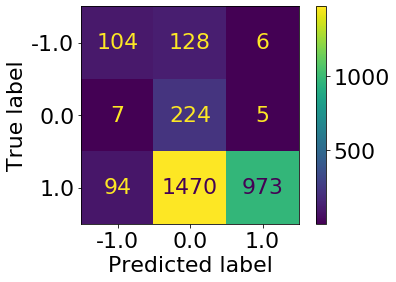

              precision    recall  f1-score   support

        -1.0       0.51      0.44      0.47       238
         0.0       0.12      0.95      0.22       236
         1.0       0.99      0.38      0.55      2537

    accuracy                           0.43      3011
   macro avg       0.54      0.59      0.41      3011
weighted avg       0.88      0.43      0.52      3011

Average test score cross validation results: 0.4193998851519347


In [118]:
# Testing TfiDf with specified words
run_models(models, X_train_tf, X_test_tf, Y_train_tf, Y_test_tf)

# Sample the data for a more even split

In [70]:
# See how many negative values we have
train_data[train_data['Sentiment'] == -1].shape

(884, 10)

In [71]:
train_data[train_data['Sentiment'] == 0].shape

(917, 10)

In [120]:
train_data[train_data['Sentiment'] == 1].shape

(10242, 10)

In [72]:
neg_sent = train_data[train_data['Sentiment'] == -1]
pos_sent = train_data[train_data['Sentiment'] == 1].sample(neg_sent.shape[0])
neut_sent = train_data[train_data['Sentiment'] == 0].sample(neg_sent.shape[0])

In [73]:
print(pos_sent.shape)

(884, 10)


In [81]:
train_data_sample = neg_sent.append(pos_sent, ignore_index=True)
train_data_sample = train_data_sample.append(neut_sent, ignore_index=True)
train_data_sample.shape

(2652, 10)

In [103]:
train_data_sample.groupby(['Sentiment']).count()

,text,entities.hashtags,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec
Sentiment,,,,,,,,,
-1.0,884,884,873,99,884,884,884,884,884
0.0,884,884,878,77,884,884,884,884,884
1.0,884,884,881,99,884,884,884,884,884


In [83]:
train_data_sample[train_data_sample['Sentiment'].isna()].shape

(0, 10)

In [84]:
train_tf_sample = apply_tfidf(train_data_sample, 'text_dec', vocab_def=vocab_list)

Count vector shape of vectorized data: (2652, 50)


In [85]:
train_tf_sample.head()

,text,entities.hashtags,Sentiment,Price_Region,Inflection_Point,Known_Pumper,exc_count,characters_nb,emoji_count,text_dec,news,update,alert,company,2021,available,#stocks,free,:brain:,hold,:rocket:,:fire:,rocket,:moneybag:,buy,:pray:,:dollar:,moon,:bangbang:,:gem:,:slot_machine:house,rich,:eyes:,:collision:,ath,offering,dump,short,public,proposed,down,red,dip,diamond,pump and dump,out,sell,sold,current,list,gold,excited,cheap,merger,bad,underwritten,wait,see,annouces,profit
0,💎💎💣💣🚀🚀🔒,[],-1.0,-1.0,NaN,0,0,9,7,:gem: :gem: :bomb: :bomb: :rocket: :rocket: :lock:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.84013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt red day my main longs all had pullback today and was able to come out positive in dah trading,[],-1.0,-1.0,NaN,0,0,114,0,rt red day my main longs all had pullback today and was able to come out positive in dah trading,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,*sees stocks are mostly red again today* “welp see ya later ✌🏽”,[],-1.0,-1.0,NaN,0,0,70,0,*sees stocks are mostly red again today* “welp see ya later ✌🏽”,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin,[],-1.0,-1.0,NaN,0,1,111,0,who keeps selling on the ask? that’s a special kind of stupid all you selling on the ask it’s stupid! anythin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(train_tf_sample.loc[:, 'news':], train_tf_sample['Sentiment'], test_size=1/4.0, random_state=0)

LogReg
0.7088989441930619


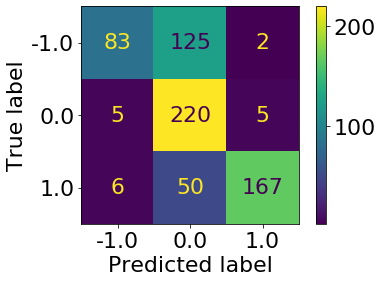

              precision    recall  f1-score   support

        -1.0       0.88      0.40      0.55       210
         0.0       0.56      0.96      0.70       230
         1.0       0.96      0.75      0.84       223

    accuracy                           0.71       663
   macro avg       0.80      0.70      0.70       663
weighted avg       0.80      0.71      0.70       663

Average test score cross validation results: 0.7058757262382442
RF
0.7088989441930619


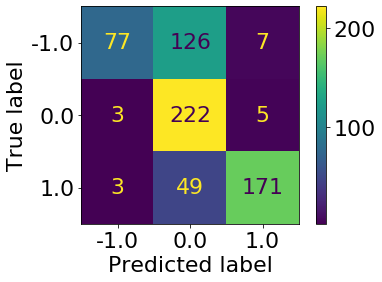

              precision    recall  f1-score   support

        -1.0       0.93      0.37      0.53       210
         0.0       0.56      0.97      0.71       230
         1.0       0.93      0.77      0.84       223

    accuracy                           0.71       663
   macro avg       0.81      0.70      0.69       663
weighted avg       0.80      0.71      0.70       663

Average test score cross validation results: 0.71341594622989
KNN
0.6334841628959276


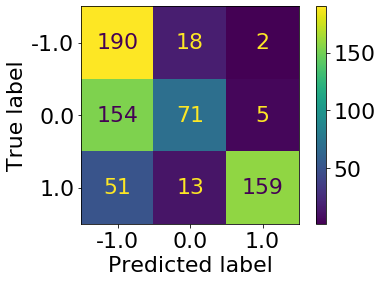

              precision    recall  f1-score   support

        -1.0       0.48      0.90      0.63       210
         0.0       0.70      0.31      0.43       230
         1.0       0.96      0.71      0.82       223

    accuracy                           0.63       663
   macro avg       0.71      0.64      0.62       663
weighted avg       0.72      0.63      0.62       663

Average test score cross validation results: 0.6847385542321177
SVM
0.7119155354449472


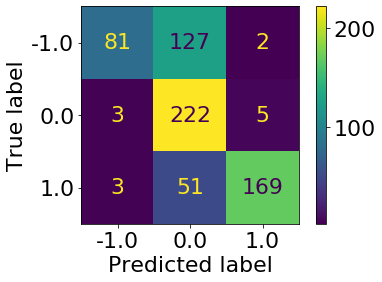

              precision    recall  f1-score   support

        -1.0       0.93      0.39      0.55       210
         0.0       0.56      0.97      0.70       230
         1.0       0.96      0.76      0.85       223

    accuracy                           0.71       663
   macro avg       0.82      0.70      0.70       663
weighted avg       0.81      0.71      0.70       663

Average test score cross validation results: 0.6988418161335646
GNB
0.6259426847662142


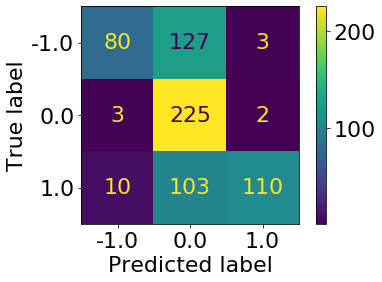

              precision    recall  f1-score   support

        -1.0       0.86      0.38      0.53       210
         0.0       0.49      0.98      0.66       230
         1.0       0.96      0.49      0.65       223

    accuracy                           0.63       663
   macro avg       0.77      0.62      0.61       663
weighted avg       0.77      0.63      0.61       663

Average test score cross validation results: 0.6309608495879904


In [87]:
run_models(models, X_train_tf, X_test_tf, Y_train_tf, Y_test_tf, [-1.0, 0.0, 1.0])

## Down select models

In [95]:
def save_model(model, file_name):
    file = open(file_name, 'wb')
    pickle.dump(model, file)

0.7088989441930619


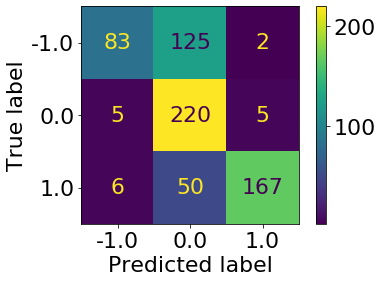

              precision    recall  f1-score   support

        -1.0       0.88      0.40      0.55       210
         0.0       0.56      0.96      0.70       230
         1.0       0.96      0.75      0.84       223

    accuracy                           0.71       663
   macro avg       0.80      0.70      0.70       663
weighted avg       0.80      0.71      0.70       663



In [99]:
log_clf = LogisticRegression(random_state=0).fit(X=X_train_tf, y=Y_train_tf)
y_pred = log_clf.predict(X_test_tf)
print(accuracy_score(Y_test_tf, y_pred))
plot_confusion_matrix(log_clf, X_test_tf, Y_test_tf)
plt.show()
print(classification_report(Y_test_tf, y_pred, labels=[-1.0, 0.0, 1.0]))

In [ ]:
rf_clf = RandomForestClassifier(random_state=0).fit(X=X_train_tf, y=Y_train_tf)

In [ ]:
# Output models 
save_model(log_clf, 'log_sent_classifier.pkl')
save_model(rf_clf, 'RF_sent_classifier.pkl')

## Trying another sampling technique with full dataset 

Yifu suggested that we duplicate data instead of downsampling.

In [148]:
neg_sent = train_data[train_data['Sentiment'] == -1]
pos_sent = train_data[train_data['Sentiment'] == 1]
neut_sent = train_data[train_data['Sentiment'] == 0]

In [149]:
print("Original shape: {}".format(neg_sent.shape))
print("Adding {} sets of duplicates".format(round(pos_sent.shape[0]/neg_sent.shape[0])))
neg_sent_dup = pd.DataFrame()
for i in range(round(pos_sent.shape[0]/neg_sent.shape[0])):
    neg_sent_dup = neg_sent_dup.append(neg_sent)
print(neg_sent_dup.shape)

Original shape: (884, 10)
Adding 12 sets of duplicates
(10608, 10)


In [150]:
print("Original shape: {}".format(neut_sent.shape))
print("Adding {} sets of duplicates".format(round(pos_sent.shape[0]/neut_sent.shape[0])))
neut_sent_dup = pd.DataFrame()
for i in range(round(pos_sent.shape[0]/neut_sent.shape[0])):
    neut_sent_dup = neut_sent_dup.append(neut_sent)
print(neut_sent_dup.shape)

Original shape: (917, 10)
Adding 11 sets of duplicates
(10087, 10)


In [154]:
full_train_data = pd.DataFrame()
full_train_data = full_train_data.append(pos_sent)
full_train_data = full_train_data.append(neg_sent_dup)
full_train_data = full_train_data.append(neut_sent_dup)
full_train_data = full_train_data.reset_index()
full_train_data.shape

(30937, 11)

In [155]:
train_tf_dup = apply_tfidf(full_train_data, 'text_dec', vocab_def=vocab_list)

Count vector shape of vectorized data: (30937, 50)


In [156]:
X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(train_tf_dup.loc[:, 'news':], train_tf_dup['Sentiment'], test_size=1/4.0, random_state=0)

LogReg


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

0.7089851325145443


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


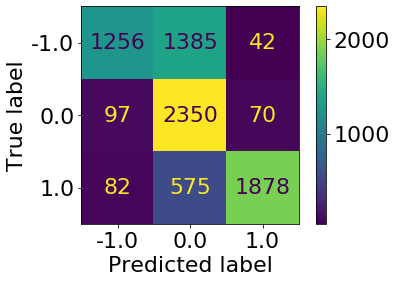

              precision    recall  f1-score   support

        -1.0       0.88      0.47      0.61      2683
         0.0       0.55      0.93      0.69      2517
         1.0       0.94      0.74      0.83      2535

    accuracy                           0.71      7735
   macro avg       0.79      0.71      0.71      7735
weighted avg       0.79      0.71      0.71      7735

Average test score cross validation results: 0.7086026997005698
RF
0.7201034259857789


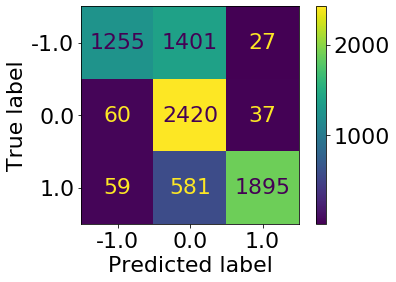

              precision    recall  f1-score   support

        -1.0       0.91      0.47      0.62      2683
         0.0       0.55      0.96      0.70      2517
         1.0       0.97      0.75      0.84      2535

    accuracy                           0.72      7735
   macro avg       0.81      0.73      0.72      7735
weighted avg       0.81      0.72      0.72      7735

Average test score cross validation results: 0.7173088625370573
KNN
0.659469941822883


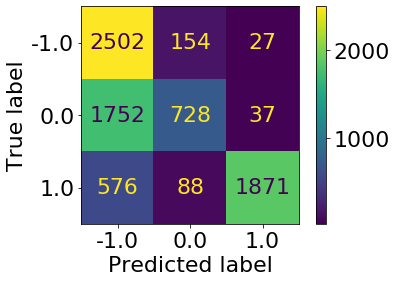

              precision    recall  f1-score   support

        -1.0       0.52      0.93      0.67      2683
         0.0       0.75      0.29      0.42      2517
         1.0       0.97      0.74      0.84      2535

    accuracy                           0.66      7735
   macro avg       0.75      0.65      0.64      7735
weighted avg       0.74      0.66      0.64      7735

Average test score cross validation results: 0.7086455802480143
SVM
0.7184227537168714


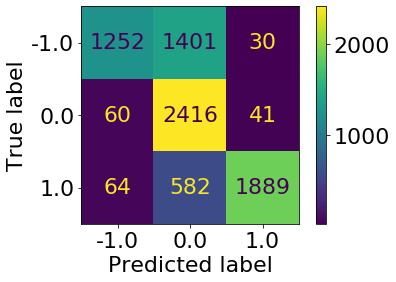

              precision    recall  f1-score   support

        -1.0       0.91      0.47      0.62      2683
         0.0       0.55      0.96      0.70      2517
         1.0       0.96      0.75      0.84      2535

    accuracy                           0.72      7735
   macro avg       0.81      0.72      0.72      7735
weighted avg       0.81      0.72      0.72      7735

Average test score cross validation results: 0.7152400456203701
GNB
0.6147382029734971


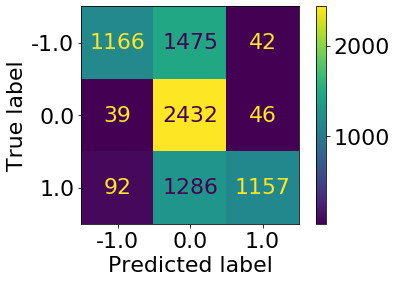

              precision    recall  f1-score   support

        -1.0       0.90      0.43      0.59      2683
         0.0       0.47      0.97      0.63      2517
         1.0       0.93      0.46      0.61      2535

    accuracy                           0.61      7735
   macro avg       0.77      0.62      0.61      7735
weighted avg       0.77      0.61      0.61      7735

Average test score cross validation results: 0.6140419536514872


In [161]:
run_models(models, X_train_tf, X_test_tf, Y_train_tf, Y_test_tf, [-1.0, 0.0, 1.0])

0.7089851325145443


C:\Users\GeorgeE\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


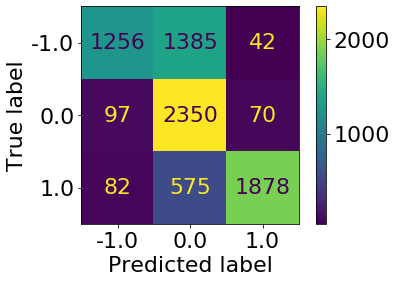

              precision    recall  f1-score   support

        -1.0       0.88      0.47      0.61      2683
         0.0       0.55      0.93      0.69      2517
         1.0       0.94      0.74      0.83      2535

    accuracy                           0.71      7735
   macro avg       0.79      0.71      0.71      7735
weighted avg       0.79      0.71      0.71      7735



In [157]:
log_clf = LogisticRegression(random_state=0).fit(X=X_train_tf, y=Y_train_tf)
y_pred = log_clf.predict(X_test_tf)
print(accuracy_score(Y_test_tf, y_pred))
plot_confusion_matrix(log_clf, X_test_tf, Y_test_tf)
plt.show()
print(classification_report(Y_test_tf, y_pred, labels=[-1.0, 0.0, 1.0]))

0.7202327084680026


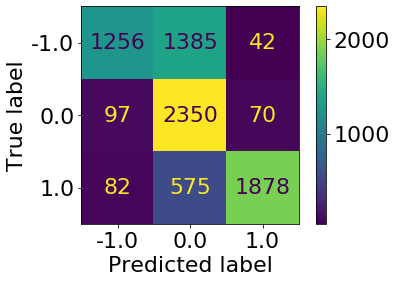

              precision    recall  f1-score   support

        -1.0       0.91      0.47      0.62      2683
         0.0       0.55      0.96      0.70      2517
         1.0       0.97      0.75      0.84      2535

    accuracy                           0.72      7735
   macro avg       0.81      0.73      0.72      7735
weighted avg       0.81      0.72      0.72      7735



In [158]:
rf_clf = RandomForestClassifier(random_state=0).fit(X=X_train_tf, y=Y_train_tf)
y_pred = rf_clf.predict(X_test_tf)
print(accuracy_score(Y_test_tf, y_pred))
plot_confusion_matrix(log_clf, X_test_tf, Y_test_tf)
plt.show()
print(classification_report(Y_test_tf, y_pred, labels=[-1.0, 0.0, 1.0]))